In [1]:
import pandas as pd
import numpy as np
import re
import pdb

from textblob import TextBlob, Word
import string
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# changing text below to markdown as not in current use

In [ ]:
#importing raw data
jobs_original = pd.read_csv('./data/alljobs_unclean.csv')
jobs_original.head()

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(jobs_original)

In [ ]:
#looks like we have a lot of duplicate jobs
#not surprising from general scraping
for column in jobs_original.columns:
    print(column, jobs_original.duplicated(subset=column).sum() )


In [ ]:
#starting by dropping all fully duplicate columns
jobs_original.drop_duplicates(keep='first').shape

In [ ]:
#looks like this loses us over half our data!
jobs_nona = jobs_original.drop_duplicates(keep='first')

In [ ]:
pandas_profiling.ProfileReport(jobs_nona)

In [ ]:
#fully duplicated description text is likely to be a true duplicate
duplicate_jds = jobs_nona[jobs_nona.duplicated(subset='job_description_all_text')]

In [ ]:
pandas_profiling.ProfileReport(duplicate_jds)

In [ ]:
#does look like some may be the same job advertised with various titles
#why are only 37 of these considered duplicated, when all of them were before?
duplicate_jds.duplicated('job_description_all_text').sum()

In [ ]:
import missingno

In [ ]:
missingno.matrix(jobs_nona)

In [ ]:
#company rating and salary are expected to be sparse
#company is not really essential, so not concerned about missing values there
#can't do much if jd text is missing, so will drop those

jobs_nona = jobs_nona.dropna(subset=['job_description_all_text'])
jobs_nona.isna().sum()

In [ ]:
# Given that only 16 are missing in company, let's look at those
jobs_nona[jobs_nona.company.isna()]

In [ ]:
duplicate_jds[duplicate_jds.duplicated('job_description_all_text')]

In [ ]:
#may still be some duplicates, but many appear to be using similar text to hire for multiple roles 
#or hiring for the same jobs in multiple locations or functions, so leaving remaining in for now

In [ ]:
#need to convert rating to float
jobs_nona.company_rating.unique()

In [ ]:
float_ratings = []
for rating in jobs_nona.company_rating:
    try:
        float_ratings.append(float(rating))
    except:
        new_rating = rating.replace(' ', '.')
        new_rating = new_rating.replace('o', '0')
        float_ratings.append(float(new_rating))

jobs_nona.company_rating = float_ratings
jobs_nona.company_rating.unique()

In [ ]:
#saving a csv file to have a shorter list of things to fix in the future
jobs_nona.to_csv('./data/alljobs_nodupes.csv', index=False)

In [2]:
#importing previously saved semi-clean file
jobs_nodupes = pd.read_csv('./data/alljobs_nodupes.csv')

In [3]:
print(jobs_nodupes.shape)
jobs_nodupes.head()

(20029, 7)


,company,company_rating,industry,job_description_all_text,job_title,location,salary_data_text
0,ANZ Banking Group,4.1,data,"Consultant Data Scientist – Data Activation, M...",Data Scientist Consultant,Melbourne,NaN
1,NAB - National Australia Bank,3.8,data,Work type: Permanent Full time\nLocation: Aust...,Data Scientist,Melbourne,NaN
2,ANZ Banking Group,4.1,data,The Team\n\nThe Customer Service Operations Au...,Senior Data Scientist,Melbourne,NaN
3,NAB - National Australia Bank,3.8,data,Work type: Permanent Full time\nLocation: Aust...,Data Analytics Engineer,Melbourne,NaN
4,Coles,3.8,data,About Us\n\nThe Digital team is focused on rei...,Data Scientist,Melbourne,NaN


In [4]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 


stop_words = set(stopwords.words('english')) 

In [5]:
#removing nltk stop-words in each jd
jd_no_stopwords = []
for jd in jobs_nodupes.job_description_all_text:
    
    translator = str.maketrans('', '', string.punctuation)
    no_stops_jd = jd.lower()
    no_stops_jd = jd.translate(translator)


    word_tokens = word_tokenize(no_stops_jd)
    filtered_jd_words = [w for w in [w.lower() for w in word_tokens] if w not in stop_words]
    
    jd_no_stopwords.append(filtered_jd_words)

jobs_nodupes['jd_no_stopwords'] = jd_no_stopwords

### Formatting salary data
Will create 3 columns:
* salary_value: the value provided in the jd or the mean of a range provided
* salary_period: frequency in jd e.g. hour, day, month, year
* annual_salary: convert all amounts to annual salary 

In [6]:
def find_salary_mean(salary_text):
    
    """accepts a collection of strings including salary numbers
    returns either the number in the text or the mean if multiple numbers"""
    
    try:
        find_numbers = re.findall('\d*', salary_text.replace(',', ''))
        salary_values = [int(number) for number in find_numbers if number != '']
        salary_mean = np.mean(salary_values)
    except:
        salary_mean = np.nan
        
    return salary_mean


In [7]:
jobs_nodupes['salary_values'] = [find_salary_mean(salary) for salary in jobs_nodupes.salary_data_text]


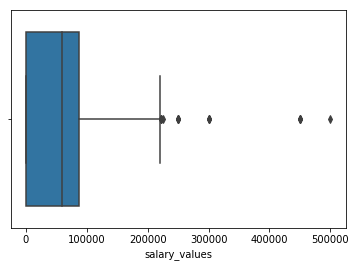

In [8]:
sns.boxplot(jobs_nodupes.salary_values)

In [9]:
jobs_nodupes[['salary_values','salary_data_text']][jobs_nodupes.salary_values > 250000]

,salary_values,salary_data_text
1363,300000.0,"$300,000 a year"
8509,300000.0,"$300,000 a year"
9073,300000.0,"$300,000 a year"
12118,300979.0,"$271,494 - $330,464 a year"
15508,500000.0,"$400,000 - $600,000 a year"
15534,450000.0,"$450,000 a year"
15543,450000.0,"$450,000 a year"
17927,450000.0,"$450,000 a year"
17956,450000.0,"$450,000 a year"


In [10]:
def find_salary_period(salary_column, pay_lengths = ['hour','day','week','month','year']):
    
    """pulls common salary timescales out of a collection of strings describing salaries"""
    
    salary_times = []
    
    for text in salary_column:
        if type(text) != str:
            salary_times.append(None)
        else:
            salary_time = 'check'
            for option in pay_lengths:
                if option in text:
                    salary_time = option
            if salary_time != 'check':
                salary_times.append(salary_time)
            else:
                salary_times.append('unknown')

    
    return(salary_times)

In [11]:
jobs_nodupes['salary_period'] = find_salary_period(jobs_nodupes.salary_data_text)

In [12]:
#no unknowns
jobs_nodupes.salary_period.value_counts()

year     3040
hour     1509
day       129
week       62
month       9
Name: salary_period, dtype: int64

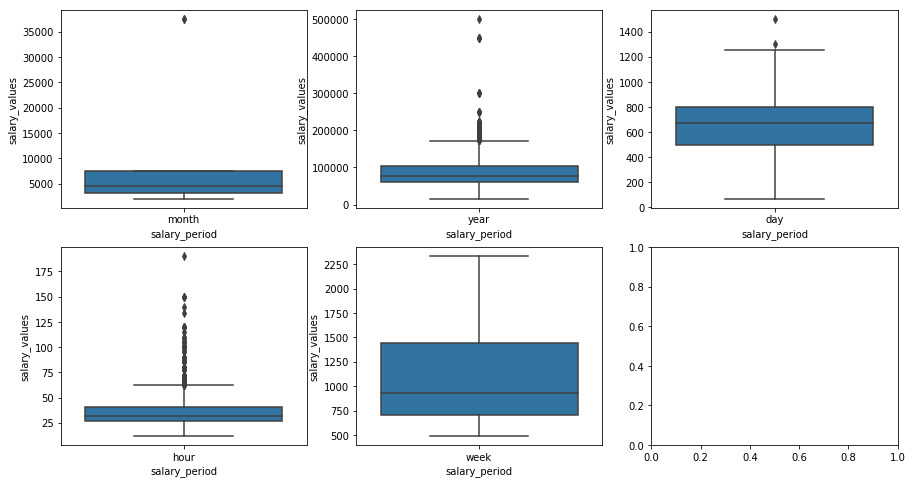

In [14]:
fig, axes = plt.subplots(2,3,figsize=(15,8))
count = 1
for time in jobs_nodupes.salary_period.unique():
    if type(time) == str:
        data = jobs_nodupes[jobs_nodupes.salary_period == time]
        axi = plt.subplot(2,3,count)
        sns.boxplot(x='salary_period', y='salary_values', data=data, ax=axi)
        count += 1



In [15]:
#one potential outlier for month
jobs_nodupes[(jobs_nodupes.salary_period == 'month') & (jobs_nodupes.salary_values > 20000)]

,company,company_rating,industry,job_description_all_text,job_title,location,salary_data_text,jd_no_stopwords,salary_values,salary_period
4199,Corex Finance,NaN,finance,Mortgage Broker AssistantCorex FinanceFull tim...,Mortgage Broker Assistant,Melbourne,"$35,000 - $40,000 a month","[mortgage, broker, assistantcorex, financefull...",37500.0,month
4252,Corex Finance,NaN,finance,Mortgage Broker AssistantCorex FinanceFull tim...,Mortgage Broker,Melbourne,"$35,000 - $40,000 a month","[mortgage, broker, assistantcorex, financefull...",37500.0,month


In [16]:
#appears to be valid, but also a duplicate
jobs_nodupes.drop(4252, inplace=True)
jobs_nodupes[(jobs_nodupes.salary_period == 'month') & (jobs_nodupes.salary_values > 20000)]

,company,company_rating,industry,job_description_all_text,job_title,location,salary_data_text,jd_no_stopwords,salary_values,salary_period
4199,Corex Finance,NaN,finance,Mortgage Broker AssistantCorex FinanceFull tim...,Mortgage Broker Assistant,Melbourne,"$35,000 - $40,000 a month","[mortgage, broker, assistantcorex, financefull...",37500.0,month


In [18]:
salary_multipliers = []

for time in jobs_nodupes.salary_period:
    if time == 'year':
        multiplier = 1
    elif time == 'month':
        multiplier = 12
    elif time == 'week':
        multiplier = 52
    elif time == 'day':
        multiplier = 260
    elif time == 'hour':
        multiplier = 2080 
    else:
        multiplier = None
        
    salary_multipliers.append(multiplier)

In [19]:
jobs_nodupes['salary_multiplier'] = salary_multipliers

In [20]:
jobs_nodupes['annual_salary'] = jobs_nodupes.salary_values * jobs_nodupes.salary_multiplier

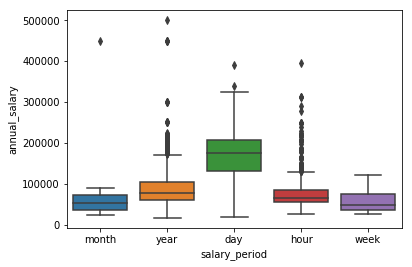

In [21]:
sns.boxplot(x='salary_period', y='annual_salary', data=jobs_nodupes)

### Checking industry values are as expected

In [22]:
jobs_nodupes.industry.value_counts()

retail            3182
finance           2832
manufacturing     2709
nursing           2346
hospitality       2203
data              1516
construction      1514
dataanalyst       1177
datascience       1086
earlylearning     1038
early_learning     425
Name: industry, dtype: int64

In [25]:
#combining data, dataanalyst, and datascience
#combining earlylearning and early_learning
jobs_nodupes.industry = jobs_nodupes.industry.map(lambda x: 'data' if 'data' in x else x)
jobs_nodupes.industry = jobs_nodupes.industry.map(lambda x: 'early_learning' if 'early' in x else x)

print(jobs_nodupes.industry.value_counts().count())
jobs_nodupes.industry.value_counts()

8


data              3779
retail            3182
finance           2832
manufacturing     2709
nursing           2346
hospitality       2203
construction      1514
early_learning    1463
Name: industry, dtype: int64

In [27]:
#saving new file with cleaned data
jobs_nodupes.to_csv('./data/alljobs_clean.csv', index=False)